In [18]:
import numpy as np
from numpy import sqrt, exp, pi, log
from scipy.sparse.linalg import eigsh
from scipy.sparse import diags
from scipy.linalg import eigh_tridiagonal as eigh_tri
from scipy.linalg import logm, expm, eigh, eigvalsh
import matplotlib.pyplot as plt
from scipy.stats import linregress

LMG Hamiltonian and would be Lyapunov exponent
$$
    \hat{H} = \Omega \, \hat x + 2 \xi \,\hat{z}^2, \qquad \lambda = \sqrt{2 \xi \Omega - \Omega^2}
$$

In [93]:
S = 500
OM = 1
XI = 2
LAM = sqrt(-OM**2+2*XI*OM)
print(LAM)

1.7320508075688772


In [94]:
xd = np.array([sqrt(S*(S+1) - m*(m+1))/(2*S) for m in range(-S, S)])
zd = np.array([m/S for m in range(-S, S+1)])
H = diags([xd, 2*zd*zd, xd], [-1, 0, 1])

In [95]:
es = eigh_tri(XI*zd*zd, OM*xd) 

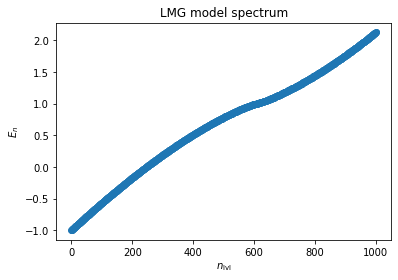

In [105]:
plt.plot(es[0], "o")
plt.title("LMG model spectrum")
plt.xlabel("$n_{\mathrm{lvl}}$")
plt.ylabel("$E_n$")
plt.show()

In [97]:
Ze = es[1].T @ np.diag(zd) @ es[1]
evol = lambda *x: exp(1.j*es[0]*x[1])[:,None] * x[0] * exp(-1.j*es[0]*x[1])[None,:]

In [103]:
tmax = 7
N = 100
tl = exp(np.linspace(log(tmax/N), log(tmax), N))

# mean energy and portion states for MC OTOC
perc = 0.01
center = OM
slc = np.abs(es[0]-center) < 0.5*perc*(es[0][-1]-es[0][0])

otocs = []
otocs_mc = []
for t in tl:
    Zet = evol(Ze, t*S)
    comm = Ze @ Zet - Zet @ Ze
    oto = -comm @ comm
    otoc = oto.trace() / (2*S + 1)
    otoc_mc = oto.diagonal()[slc].sum() / len(oto.diagonal()[slc])
    otocs.append(otoc)
    otocs_mc.append(otoc_mc)
otocs = np.array(otocs)
otocs_mc = np.array(otocs_mc)

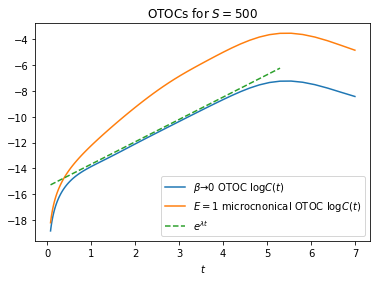

In [104]:
plt.plot(tl, log(np.abs(otocs)), label=r"$\beta \to 0$ OTOC $\log C(t)$")
plt.plot(tl, log(np.abs(otocs_mc)), label=r"$E={}$ microcnonical OTOC $\log C(t)$".format(center))
shift = np.abs(LAM*tl[:otocs.argmax()] - log(otocs[:otocs.argmax()])).min()
plt.plot(tl[:otocs.argmax()], LAM*tl[:otocs.argmax()] - shift*0.99, "--", label="$e^{\lambda t}$")
plt.xlabel(r"$t$")
plt.title(r"OTOCs for $S={}$".format(S))
plt.legend()
plt.savefig("MC_S={}.pdf".format(S))
plt.show()